In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import torch
import numpy as np
import cvxpy as cp
from scipy.stats import multivariate_normal
import numpy.polynomial as polynomial
from osmm import OSMM

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

In [3]:
CPU = torch.device('cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda')
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    device = CPU
print("device =", device)

device = cpu


## generate data

In [4]:
N_0 = 10000
lam_reg = 0
importance_sampling = False
d = 2
m = 2000
degree = 4
n = int((degree + 1) * (degree + 2) / 2 - 1)

In [5]:
Sigma1 = np.diag([0.5 ** 2] * d)
Sigma2 = np.diag([0.5 ** 2] * d)
Sigma3 = np.diag([0.5 ** 2] * d)
mu1 = 1.0 * np.ones(d)
mu2 = -1.0 * np.ones(d)
mu3 = np.array([1.0, -1.0])
prob1 = .4
prob2 = .3
prob3 = .3
y = np.vstack([
    np.random.multivariate_normal(mu1, Sigma1, size=int(m * prob1)),
    np.random.multivariate_normal(mu2, Sigma2, size=int(m * prob2)),
    np.random.multivariate_normal(mu3, Sigma3, size=int(m * prob3))
]).T

y = y / np.max(np.abs(y))

y_mean = np.mean(y, axis=1)
y_cov = np.cov(y - y_mean[:, None])

In [6]:
def phi(x):
    _, num_points = x.shape
    phi_val = np.zeros((n, num_points))
    count = 0
    for i in range(degree + 1):
        for j in range(degree - i + 1):
            if i > 0 or j > 0:
                # phi_val[count, :] = np.power(x[0, :], i) * np.power(x[1, :], j)
                coeff_Legendre = np.zeros((degree + 1, degree + 1))
                coeff_Legendre[i, j] = 1
                phi_val[count, :] = polynomial.legendre.legval2d(x[0, :], x[1, :], coeff_Legendre)
                count += 1
    return phi_val


def Dphi():
    z = np.random.multivariate_normal(y_mean, y_cov * 1.1, N_0)
    z_inf_norms = np.max(np.abs(z), axis=1)
    z_acc = z[z_inf_norms <= 1, :]
    log_sampling_normalizer_pdf = multivariate_normal.logpdf(z_acc, y_mean, y_cov * 1.1)
    z_acc = z_acc.T
    _, N = z_acc.shape
    log_pi_z = - log_sampling_normalizer_pdf.reshape((1, N)) - np.log(N_0)
    Dphi_mtx = np.zeros((N, n, d))  # d=2
    Dphi_mtx_transpose = np.zeros((N, d, n))  # d=2
    count = 0
    for i in range(degree + 1):
        for j in range(degree - i + 1):
            if i > 0 or j > 0:
                coeff_Legendre = np.zeros((degree + 1, degree + 1))
                coeff_Legendre[i, j] = 1
                partial_x_coeff = polynomial.legendre.legder(coeff_Legendre, m=1, axis=0)
                partial_y_coeff = polynomial.legendre.legder(coeff_Legendre, m=1, axis=1)
                Dphi_mtx[:, count, 0] = polynomial.legendre.legval2d(z_acc[0, :], z_acc[1, :], partial_x_coeff)
                Dphi_mtx[:, count, 1] = polynomial.legendre.legval2d(z_acc[0, :], z_acc[1, :], partial_y_coeff)
                Dphi_mtx_transpose[:, 0, count] = Dphi_mtx[:, count, 0]
                Dphi_mtx_transpose[:, 1, count] = Dphi_mtx[:, count, 1]
                count += 1
    Dphi_DphiT_mtx = np.matmul(Dphi_mtx, Dphi_mtx_transpose)
    result = np.sum(Dphi_DphiT_mtx.T * np.exp(log_pi_z), axis=2)
    return result

In [7]:
phi_y = phi(y)
c = np.sum(phi_y, axis=1)

D_reg = Dphi()
n_w = n + 1

In [8]:
def generate_random_data():
    if importance_sampling:
        z = np.random.multivariate_normal(y_mean, y_cov * 1.1, N_0)
        z_inf_norms = np.max(np.abs(z), axis=1)
        z_acc = z[z_inf_norms <= 1, :]
        log_sampling_normalizer_pdf = multivariate_normal.logpdf(z_acc, y_mean, y_cov * 1.1)
        z_acc = z_acc.T
    else:
        z_acc = np.zeros((2, N_0))
        for j in range(int(np.sqrt(N_0))):
            for i in range(int(np.sqrt(N_0))):
                z_acc[0, i + j * int(np.sqrt(N_0))] = -1 + i * 2 / int(np.sqrt(N_0))
                z_acc[1, i + j * int(np.sqrt(N_0))] = -1 + j * 2 / int(np.sqrt(N_0))
        log_sampling_normalizer_pdf = np.log(np.ones(N_0) / 4)
    _, N = z_acc.shape
    log_pi_z = - log_sampling_normalizer_pdf.reshape((1, N)) - np.log(N_0)
    phi_z = phi(z_acc)
    W = np.concatenate([phi_z, log_pi_z])
    return W

In [9]:
W = generate_random_data()

## define g and f

In [10]:
theta_var = cp.Variable(n)
g_obj = lam_reg * cp.quad_form(theta_var, D_reg)

In [11]:
def my_f_torch(theta_torch, W_torch):
    _, batch_size = W_torch.shape
    phi_z_torch = W_torch[0:n, :]
    log_pi_z_torch = W_torch[n_w - 1, :]
    A_theta = torch.logsumexp(torch.matmul(-phi_z_torch.T, theta_torch) + log_pi_z_torch, 0)
    return A_theta + torch.matmul(theta_torch.T, torch.tensor(c / m, dtype=torch.float))

## consturct osmm object

In [12]:
osmm_prob = OSMM()
osmm_prob.f_torch.function = my_f_torch
osmm_prob.f_torch.W = W
osmm_prob.g_cvxpy.variable = theta_var
osmm_prob.g_cvxpy.objective = g_obj
osmm_prob.g_cvxpy.constraints = []

## solve

In [13]:
init_val = np.ones(n) / n
osmm_prob.solve(init_val, verbose=True, 
#                 use_termination_criteria=False
               )

lower bound problem error: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
iter = 10, objf = 6.169e-01, lower bound = -inf, RMS residual = 9.683e-03, ||G||_F = 1.142e+00
lower bound problem error: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
iter = 20, objf = 5.992e-01, lower bound = -inf, RMS residual = 8.747e-04, ||G||_F = 1.111e+00
      Terminated. Num iterations = 27, objf = 5.950e-01, lower bound = -inf, RMS residual = 8.540e-05.
      Time elapsed (secs): 0.557504.



0.595034122467041

## plot result

In [14]:
total_iters = osmm_prob.method_results["total_iters"]
iters = np.array([i for i in range(0, total_iters + 1)])

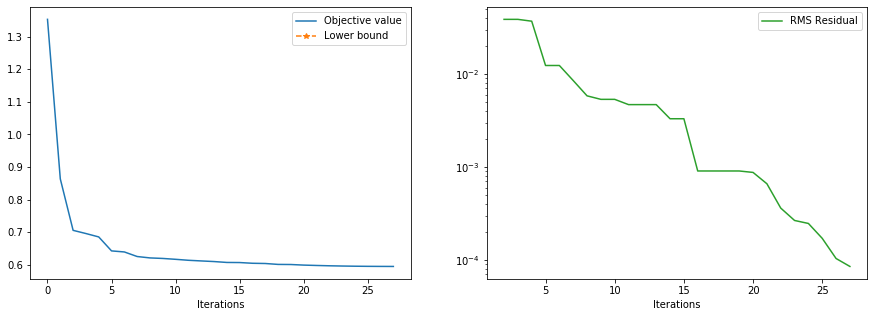

In [15]:
fig = plt.figure(tight_layout=False, figsize=(15, 5))
gs = gridspec.GridSpec(1, 2)

plot1 = fig.add_subplot(gs[0, 0])
plot1.plot(iters, osmm_prob.method_results["objf_iters"][0:total_iters + 1], label="Objective value")
lower_bound_idxs = [i for i in range(0, total_iters + 1, 10)] + [total_iters]
plot1.plot(iters[lower_bound_idxs], osmm_prob.method_results["lower_bound_iters"][lower_bound_idxs], 
           '--*', label="Lower bound")

plot1.set_xlabel("Iterations")
plot1.legend()

#=========================================================================================================
plot2 = fig.add_subplot(gs[0, 1])
start_idx = 2
rms_res_running_min = np.array(osmm_prob.method_results["rms_res_iters"][0:total_iters + 1])
for i in range(start_idx, total_iters + 1):
    rms_res_running_min[i] = np.min(osmm_prob.method_results["rms_res_iters"][start_idx:i + 1])

plot2.plot(iters[start_idx::], rms_res_running_min[start_idx::], label="RMS Residual", color='#2ca02c')

plot2.set_xlabel("Iterations")
plot2.set_yscale("log")
plot2.legend()

In [16]:
font = {'family': 'serif',
        'size': 16,}

best_iter = np.argmin(osmm_prob.method_results["objf_iters"][0:total_iters])
objf_best = osmm_prob.method_results["objf_iters"][best_iter]
A_theta_value = objf_best - c.T.dot(osmm_prob.method_results["soln"]) / m

([<matplotlib.axis.XTick at 0x7f81dab13090>,
 <a list of 5 Text yticklabel objects>)

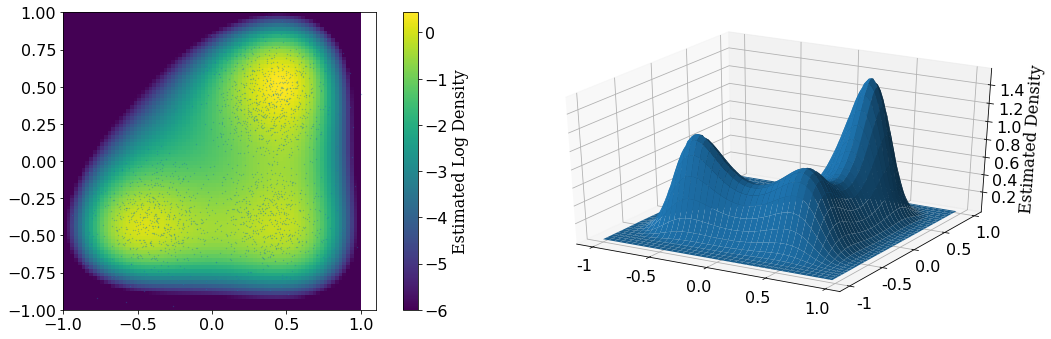

In [17]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(tight_layout=True, figsize=(16, 5))
gs = gridspec.GridSpec(1, 2)

a = fig.add_subplot(gs[0, 0])
delta = 0.025
axis_range = 1
x_axis = y_axis = np.arange(-axis_range, axis_range, delta)
X, Y = np.meshgrid(x_axis, y_axis)
points_for_plots = np.zeros((2, len(x_axis) ** 2))
points_for_plots[0, :] = X.reshape((1, len(x_axis) ** 2), order="F")
points_for_plots[1, :] = Y.reshape((1, len(x_axis) ** 2), order="F")
phi_for_plots = phi(points_for_plots)
phi_T_theta_for_plots = osmm_prob.method_results["soln"].dot(phi_for_plots)
log_prob = -phi_T_theta_for_plots.reshape(len(x_axis), len(x_axis), order="F")
im = a.imshow(np.maximum(-6, log_prob - A_theta_value), interpolation=None, origin='lower',
                  extent=[-axis_range, axis_range, -axis_range, axis_range])
cbar = fig.colorbar(im)
cbar.set_label('Estimated Log Density', fontdict=font)
cbar.ax.tick_params(labelsize=16)
a.scatter(y[0, :], y[1, :], alpha=0.5, s=0.1)
a.tick_params(labelsize=16)

# ####################################################################
c_fig = fig.add_subplot(gs[0, 1], projection='3d')
c_fig.plot_surface(X, Y, np.exp(np.maximum(-20, log_prob - A_theta_value)))
c_fig.set_zlabel("Estimated Density", fontdict=font)
c_fig.tick_params(labelsize=16)
plt.xticks(np.array([-1, -0.5, 0.0, 0.5, 1.0]), [-1, -0.5, 0.0, 0.5, 1.0])
plt.yticks(np.array([-1, -0.5, 0.0, 0.5, 1.0]), [-1, -0.5, 0.0, 0.5, 1.0])